In [1]:
# When running on Colab, get access to Google Drive to read the d2l utility file
try:
    from google.colab import drive
    drive.mount('/gdrive', force_remount=True)
    import sys
    sys.path.append('/gdrive/MyDrive/Colab Notebooks')
except:
    pass

Mounted at /gdrive


In [3]:
! pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import d2l
import torch
from torch import nn
from d2l import Accumulator
from IPython import display
from d2l import Animator
import torchvision
from torchvision import transforms
from torch.utils import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from torchsummary import summary
from einops.layers.torch import Rearrange

# Task 1 : Reading the data and Creating Data Loaders

In [3]:
# Defining a function for downloading and loading KMNIST dataset

def load_data_kmnist(batch_size, resize=None):
  # Transforming images to tensors
    trans = [transforms.ToTensor()]   
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    kmnist_train = torchvision.datasets.KMNIST(
        root="../data", train=True, transform=trans, download=True)
    kmnist_test = torchvision.datasets.KMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(kmnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(kmnist_test, batch_size, shuffle=False,
                            num_workers=4),kmnist_train,kmnist_test)

In [4]:
# Reading training and test data and iterators created via dataloaders
batch_size = 256
train_iter, test_iter,train_data, test_data = load_data_kmnist(batch_size, resize = 32)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
# Checking the number of samples in training and test dataset
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [6]:
# Getting size of our data
X,y = next(iter(train_iter))
print(X.size())
print(y.size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 1, 32, 32])
torch.Size([256])


### Let's load some of the training images to have a peek on our data and ensure that it is in order

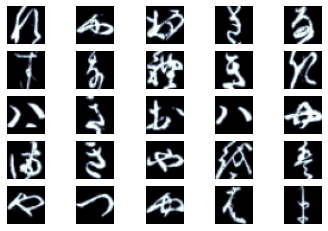

In [7]:
def show_images(images):

    n = len(images)

    rows = int(np.sqrt(n))
    cols = int(np.sqrt(n))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(32, 32).cpu().numpy(), cmap='bone')
        ax.axis('off')

N = 25 # Number of images to be printed
images = [image for image, label in [train_data[i] for i in range(N)]]
show_images(images)

# Task 2: Creating Model

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self, d, Np):
        super().__init__()
       # Defining layer normalization layers
        self.Norm1 = nn.LayerNorm(d)
        self.Norm2 = nn.LayerNorm(d)
    # Block

       # Defining the First MLP 
        self.mlp1 = nn.Sequential(
                            nn.Linear(Np, d),
                            nn.GELU(),
                            nn.Dropout(0.1),
                            nn.Linear(d, Np),
                            nn.Dropout(0.1)
                            )
        # Defining the Second MLP
        self.mlp2 = nn.Sequential(
                            nn.Linear(d, d),
                            nn.GELU(),
                            nn.Dropout(0.1),
                            nn.Linear(d, d),
                            nn.Dropout(0.1)
                            )
        
    def forward(self, x):
      # Passing the input to first Normalization Layer
        norm1_out =self.Norm1(x)
      # Transposing the input for first MLP
        input_transposed = norm1_out.transpose(1,2)
      # Passing the transposed input to first MLP
        mlp1_out = self.mlp1(input_transposed)
      # Tasnposing the output of first MLP to be passed to second MLP
        mlp1_transposed = mlp1_out.transpose(1,2)
      # Passing the trasnposed MLP1 output to the second normalization layer
        norm2_out = self.Norm2(mlp1_transposed)
      # passing the normalized output to second MLP
        mlp2_out = self.mlp2(norm2_out)
      # Returns the output of MLP2 to be taken as input for the next block
        return mlp2_out

In [9]:
class MLPNet(nn.Module):
    def __init__(self,input_size, patch_size, d = 64, blocks = 4, num_classes=10):
        super().__init__()

     # Stem
        
        assert (input_size[0] % patch_size[0]) == 0  # to check whether our patch size is divisible by image size
        assert (input_size[1] % patch_size[1]) == 0
        # Calculating Number of patches that will be made for the patch_size given
        Np = int(input_size[0]/patch_size[0] * input_size[1]/patch_size[1])
        # Getting patch dimensions
        patch_dim = patch_size[0] * patch_size[1]
        # Creating patches using Rearrange and a LInear Layer
        self.to_patch_embedding = nn.Sequential(
                    # Transforming into vectors
                    Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size[0], p2 = patch_size[1]),
                    # Linear Layer
                    nn.Linear(patch_dim, d))

     # Running 4 Blocks
        self.network = nn.Sequential(*[nn.Sequential(MLPBlock(d,Np)) for _ in range(blocks)])
    
     # Calculating mean_feature
        self.mean_feature = nn.AdaptiveAvgPool1d(1)
     # Classifier
        self.classifier = nn.Linear(d,num_classes)
    
    def forward(self,x):
        x = self.to_patch_embedding(x)
        x = self.network(x)
        return self.classifier(self.mean_feature(x.transpose(1,2)).squeeze(2))
    

### Model Instantiation and Weight Initialisation -- Using Zero Initialisation for Bias and Random Initialisation for Weights

In [10]:
#initialise weights and bias
def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    nn.init.xavier_normal_(m.weight)
    nn.init.zeros_(m.bias)
# Instantiate model with initiated weights and biases
net = MLPNet((32,32),(4,4),64,4,10)
net.apply(init_weights)

MLPNet(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): Linear(in_features=16, out_features=64, bias=True)
  )
  (network): Sequential(
    (0): Sequential(
      (0): MLPBlock(
        (Norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (Norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp1): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=64, out_features=64, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
        (mlp2): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=64, out_features=64, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

# Task 3: Creating Loss and Optimizer

In [11]:
# Using CrossEntropyLoss as loss function
loss = nn.CrossEntropyLoss()

# Using Adam as the optimiser
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)

# Task 4: Model Training

In [12]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

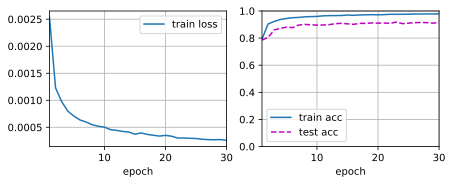

In [13]:
num_epochs = 30
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

In [17]:
print("\nThe train accuracy is: ",evaluate_accuracy(net, train_iter)*100,"%")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



The train accuracy is:  98.92 %


In [15]:
print("\nThe test accuracy is: ",evaluate_accuracy(net, test_iter)*100,"%")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



The test accuracy is:  91.58 %
